### Author: Prasad Pooja
### Date: 13 Jan 2019
### Title: NS Project
### Purpose: Data Science project on predicting Nephrotic Syndrome using ML techniques

## Problem Introduction
We have patient dataset. Goal is to predict the Nephrotic Syndrome. Each row in the dataset is one visit to the store. 
It’s supervised because we have both the features (data from the visist) and the targets (total transaction revenue) that we want to predict. During training, we give the random forest and gradient boosting both the features and targets and it must learn how to map the data to a prediction. Moreover, this is a regression task because the target value is continuous (as opposed to discrete classes in classification). 
We also train our features on K-Means and Gaussian Mixture and discussed the results.
PCA and ISO map are also implemented on the dataset.
That’s pretty much all the background we need, so let’s start!

## 1. Load libraries

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
from scipy import stats
import datetime
from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc
from sklearn.model_selection import cross_val_score, GridSearchCV #Perforing grid search
from sklearn.metrics import confusion_matrix ,mean_squared_error

from sklearn.tree import DecisionTreeClassifier

## 2. Read Data

In [109]:
%%time
print('Time taken to read the data:')
df_data = pd.read_excel(r'C:\Users\pooja\Dropbox\1_Pooja_Prasad\02UTD_Aug2018\ComputerVision\NS In Adults_v5.xlsx',)


Time taken to read the data:
Wall time: 29.1 ms


In [110]:
df_data.drop(['Name','TissueDiagnosisCause','Date'], axis=1, inplace = True)

In [111]:
print('The shape of our original dataset is:', df_data.shape)

The shape of our original dataset is: (50, 20)


In [112]:
df_data.head()

,Age,Gender,ProteinuriaOnDipstick,SerumAlbumin,SerumCholestrol,SerumCr,24HrsUrineProtein,UrineRBC,UrinePusCells,UrineCast,HBSAg,HIV,HCV,ANA,Diabetic,Edema,EdemaDurationInMonths,BPSystolic,BPDiastolic,NephroticSyndromeClassification
0,30,M,4+,3.1,222,1.9,2.5,1.2,29.0,0,0,0,0,0,0,1,36.0,122,80,Mild
1,26,M,4+,3.0,389,2.5,5.0,25.0,0.0,1,1,0,0,0,0,1,1.0,140,100,Moderate
2,18,M,4+,3.0,360,0.9,4.0,0.0,0.0,0,0,0,0,0,0,1,4.0,140,100,Moderate
3,35,M,3+,1.5,347,1.4,5.9,0.0,0.0,0,0,0,0,0,0,1,1.5,144,110,Moderate
4,60,F,4+,2.5,359,0.8,3.5,0.0,0.0,0,0,0,0,0,0,1,8.0,140,90,Moderate


In [113]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
Age                                50 non-null int64
Gender                             50 non-null object
ProteinuriaOnDipstick              50 non-null object
SerumAlbumin                       50 non-null float64
SerumCholestrol                    50 non-null int64
SerumCr                            50 non-null float64
24HrsUrineProtein                  50 non-null float64
UrineRBC                           50 non-null float64
UrinePusCells                      50 non-null float64
UrineCast                          50 non-null int64
HBSAg                              50 non-null int64
HIV                                50 non-null int64
HCV                                50 non-null int64
ANA                                50 non-null int64
Diabetic                           50 non-null int64
Edema                              50 non-null int64
EdemaDurationInMonths              50

In [114]:
df_data.isnull().astype(int).sum()

Age                                0
Gender                             0
ProteinuriaOnDipstick              0
SerumAlbumin                       0
SerumCholestrol                    0
SerumCr                            0
24HrsUrineProtein                  0
UrineRBC                           0
UrinePusCells                      0
UrineCast                          0
HBSAg                              0
HIV                                0
HCV                                0
ANA                                0
Diabetic                           0
Edema                              0
EdemaDurationInMonths              0
BPSystolic                         0
BPDiastolic                        0
NephroticSyndromeClassification    0
dtype: int64

### Checking for NaN values in the dataframe columns

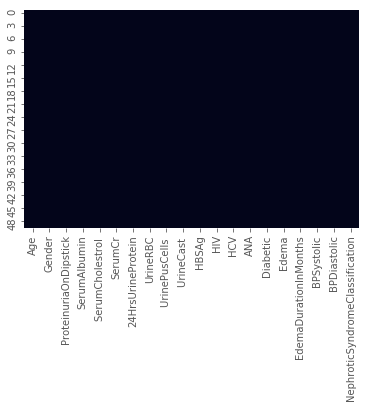

In [115]:
sns.heatmap(df_data.isnull(), cbar=False)

### EDA

## Imbalanced data - the classes are not represented equally.

In [116]:
df_data['NephroticSyndromeClassification'].unique()

array(['Mild', 'Moderate', 'Normal', 'Severe'], dtype=object)

In [117]:
df_data['NephroticSyndromeClassification'].value_counts()

Moderate    24
Mild        11
Severe       9
Normal       6
Name: NephroticSyndromeClassification, dtype: int64

In [118]:
df_data['NephroticSyndromeClassification'].value_counts().index

Index(['Moderate', 'Mild', 'Severe', 'Normal'], dtype='object')

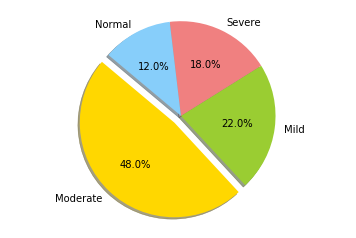

In [119]:
import matplotlib.pyplot as plt
 
# Data to plot
labels =df_data['NephroticSyndromeClassification'].value_counts().index
sizes = df_data['NephroticSyndromeClassification'].value_counts()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


Accuracy is not the metric to use when working with an imbalanced dataset. Thus, when comparing approaches to imbalanced classification problems, consider using metrics beyond accuracy such as recall, precision, and AUROC.
recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Oversampling the minority can lead to model overfitting, since it will introduce duplicate instances, drawing from a pool of instances that is already small. Similarly, undersampling the majority can end up leaving out important instances that provide important differences between the two classes.
SMOTE, which actually creates new instances of the minority class by forming convex combinations of neighboring instances.

### 9.2 One hot vector for categorical features

In [120]:
df_data['ProteinuriaOnDipstick'].unique()

array(['4+', '3+', '2+'], dtype=object)

In [121]:
df_data['ProteinuriaOnDipstick'] = df_data['ProteinuriaOnDipstick'].map({ '2+':1, '3+':2, '4+':3})

In [122]:
df_data['Gender'] = df_data['Gender'].map({'M':0, 'F':1}).astype(int)

In [123]:
df_data['NephroticSyndromeClassification'] = df_data['NephroticSyndromeClassification'].map({'Normal':0, 'Mild':1, 'Moderate':2, 'Severe':3,}).astype(int)

In [124]:
df_data.head()

,Age,Gender,ProteinuriaOnDipstick,SerumAlbumin,SerumCholestrol,SerumCr,24HrsUrineProtein,UrineRBC,UrinePusCells,UrineCast,HBSAg,HIV,HCV,ANA,Diabetic,Edema,EdemaDurationInMonths,BPSystolic,BPDiastolic,NephroticSyndromeClassification
0,30,0,3,3.1,222,1.9,2.5,1.2,29.0,0,0,0,0,0,0,1,36.0,122,80,1
1,26,0,3,3.0,389,2.5,5.0,25.0,0.0,1,1,0,0,0,0,1,1.0,140,100,2
2,18,0,3,3.0,360,0.9,4.0,0.0,0.0,0,0,0,0,0,0,1,4.0,140,100,2
3,35,0,2,1.5,347,1.4,5.9,0.0,0.0,0,0,0,0,0,0,1,1.5,144,110,2
4,60,1,3,2.5,359,0.8,3.5,0.0,0.0,0,0,0,0,0,0,1,8.0,140,90,2


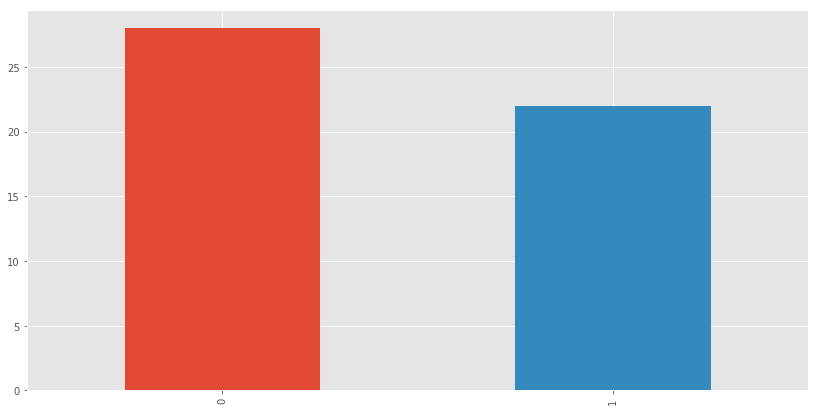

In [125]:
plt.figure(figsize=(14,7)) # this creates a figure 14 inch wide, 7 inch high
df_data['Gender'].value_counts().plot('bar')

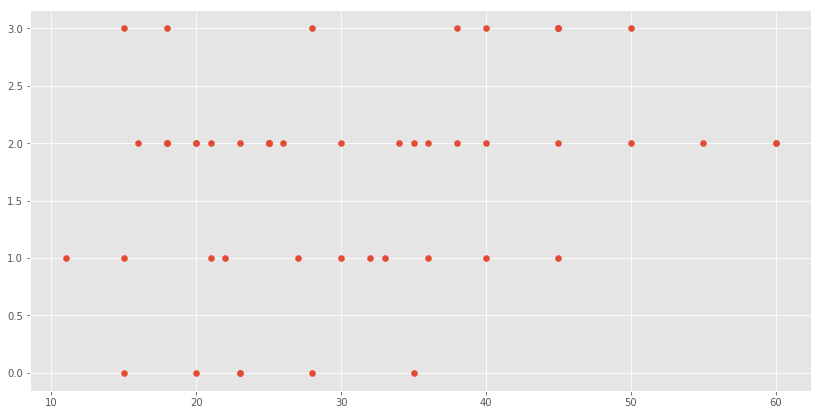

In [126]:
plt.figure(figsize=(14,7)) # this creates a figure 14 inch wide, 7 inch high
plt.scatter(x='Age',y='NephroticSyndromeClassification',data=df_data) 

## 9. Supervised Learning

### 9.3 Features and Labels

In [127]:
X = df_data.drop('NephroticSyndromeClassification',1)
y = df_data['NephroticSyndromeClassification']

In [128]:
Features_NS = df_data[df_data['NephroticSyndromeClassification'] > 0]
Features_NS.head()

,Age,Gender,ProteinuriaOnDipstick,SerumAlbumin,SerumCholestrol,SerumCr,24HrsUrineProtein,UrineRBC,UrinePusCells,UrineCast,HBSAg,HIV,HCV,ANA,Diabetic,Edema,EdemaDurationInMonths,BPSystolic,BPDiastolic,NephroticSyndromeClassification
0,30,0,3,3.1,222,1.9,2.5,1.2,29.0,0,0,0,0,0,0,1,36.0,122,80,1
1,26,0,3,3.0,389,2.5,5.0,25.0,0.0,1,1,0,0,0,0,1,1.0,140,100,2
2,18,0,3,3.0,360,0.9,4.0,0.0,0.0,0,0,0,0,0,0,1,4.0,140,100,2
3,35,0,2,1.5,347,1.4,5.9,0.0,0.0,0,0,0,0,0,0,1,1.5,144,110,2
4,60,1,3,2.5,359,0.8,3.5,0.0,0.0,0,0,0,0,0,0,1,8.0,140,90,2


In [129]:
Features_NS = Features_NS.drop('NephroticSyndromeClassification',1)

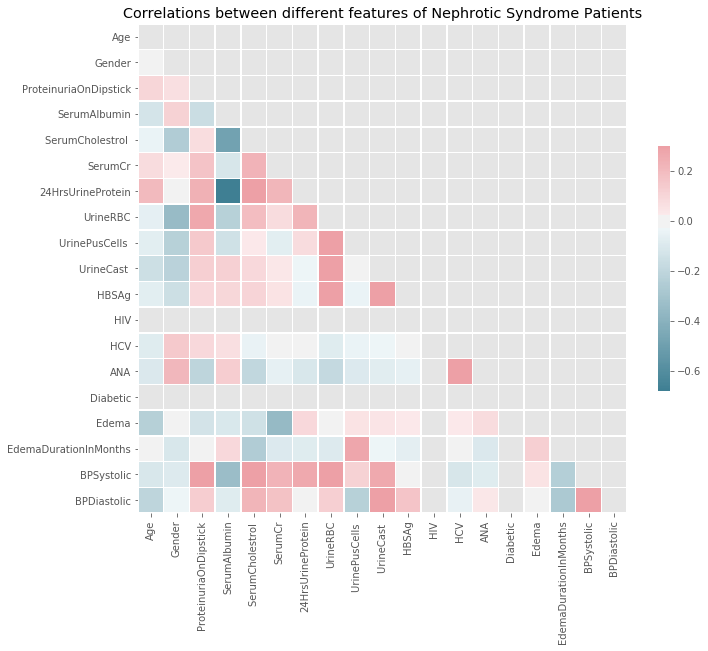

In [130]:
corr_df = Features_NS.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different features of Nephrotic Syndrome Patients')
plt.show()

### 9.4 Training and Testing Sets

In [166]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [132]:
#print(X_train.shape, y_train.shape)

In [133]:
#print(X_test.shape, y_test.shape)

In [167]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=3, ratio = 1.0)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [169]:
print(X_smote.shape, y_smote.shape)

(76, 19) (76,)


In [197]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler to your data
X_smote_scaled = scaler.fit_transform(X_smote)

In [198]:
X_test_scaled = scaler.fit_transform(X_test)

In [171]:
from sklearn.model_selection import GridSearchCV #Perforing grid search
parameters = {'max_depth':np.arange(1,5,1)}
model=DecisionTreeClassifier(random_state=42)
#gsearch1 = GridSearchCV(model,parameters,scoring='r2',cv=None)

evaluation_metric = ['precision_macro', 'recall_macro','f1_macro']
for i in evaluation_metric:
    gsearch1 = GridSearchCV(model,parameters,scoring=i,cv=5) 
    gsearch1.fit(X_smote,y_smote)
    print("Best param for",i,"are: ",gsearch1.best_params_)
    print("Best score for",i,"are: ",gsearch1.best_score_)

Best param for precision_macro are:  {'max_depth': 3}
Best score for precision_macro are:  0.9684210526315788
Best param for recall_macro are:  {'max_depth': 3}
Best score for recall_macro are:  0.9605263157894737
Best param for f1_macro are:  {'max_depth': 3}
Best score for f1_macro are:  0.9598997493734336


C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\m

In [202]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_smote, y_smote) 
dtree_predictions = dtree_model.predict(X_test)


In [203]:
print(classification_report(y_test,dtree_predictions))

             precision    recall  f1-score   support

          0       1.00      0.50      0.67         2
          1       0.50      1.00      0.67         1
          2       1.00      1.00      1.00         5
          3       1.00      1.00      1.00         5

avg / total       0.96      0.92      0.92        13



In [204]:
# from sklearn.model_selection import cross_validate
# from sklearn.metrics import recall_score
# scoring = ['precision_macro', 'recall_macro','f1_macro']

# scores = cross_validate(dtree_model, X_smote, y_smote, scoring=scoring, cv=5, return_train_score=False)


In [205]:
# scores['test_f1_macro'].mean()

In [206]:
# scores['test_precision_macro'].mean()

In [207]:
# scores['test_recall_macro'].mean()

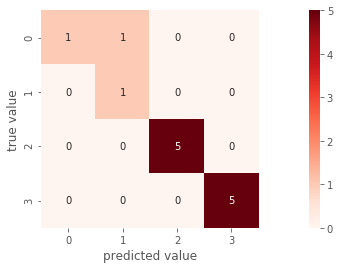

In [208]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions)
plt.subplots(figsize = (18,4))
sns.heatmap(cm, square=True, annot=True, cbar=True , cmap = 'Reds')
plt.xlabel('predicted value')
plt.ylabel('true value');

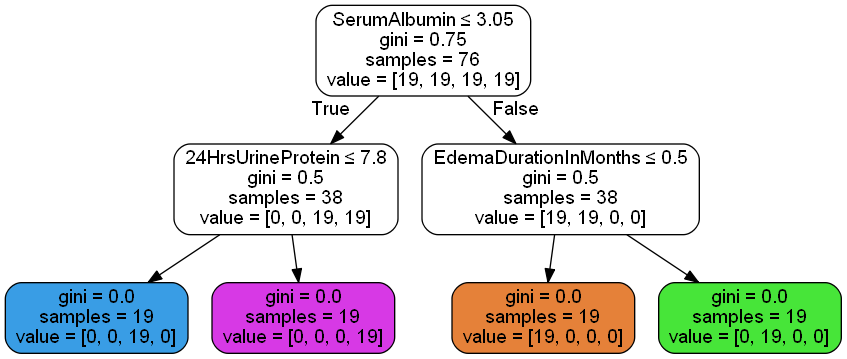

In [209]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree_model, out_file=dot_data,  
                filled=True, rounded=True,feature_names=X.columns,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [176]:
from sklearn.svm import SVC 
parameters = {'C':[0.01,0.1,1],'tol':[0.001,0.01,0.1]}
model=SVC(random_state=42)
#gsearch1 = GridSearchCV(model,parameters,scoring='r2',cv=None)

evaluation_metric = ['precision_macro', 'recall_macro','f1_macro']
for i in evaluation_metric:
    gsearch1 = GridSearchCV(model,parameters,scoring=i,cv=5) 
    gsearch1.fit(X_smote,y_smote)
    print("Best param for",i,"are: ",gsearch1.best_params_)
    print("Best score for",i,"are: ",gsearch1.best_score_)

C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\m

Best param for precision_macro are:  {'C': 1, 'tol': 0.001}
Best score for precision_macro are:  0.7096230158730159
Best param for recall_macro are:  {'C': 1, 'tol': 0.001}
Best score for recall_macro are:  0.618421052631579
Best param for f1_macro are:  {'C': 1, 'tol': 0.001}
Best score for f1_macro are:  0.5827570090727986


C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\c

In [195]:
# training a linear SVM classifier 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_smote, y_smote)  
svm_predictions = svm_model_linear.predict(X_test) 

In [196]:
print(classification_report(y_test,svm_predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       0.50      1.00      0.67         1
          2       0.50      0.60      0.55         5
          3       0.67      0.40      0.50         5

avg / total       0.64      0.62      0.61        13



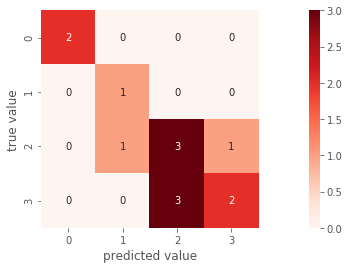

In [178]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions)
plt.subplots(figsize = (18,4))
sns.heatmap(cm, square=True, annot=True, cbar=True , cmap = 'Reds')
plt.xlabel('predicted value')
plt.ylabel('true value');

In [189]:
from sklearn.neighbors import KNeighborsClassifier 
parameters = {'n_neighbors':[1,3,5,7]}
model=KNeighborsClassifier()
#gsearch1 = GridSearchCV(model,parameters,scoring='r2',cv=None)

evaluation_metric = ['precision_macro', 'recall_macro','f1_macro']
for i in evaluation_metric:
    gsearch1 = GridSearchCV(model,parameters,scoring=i,cv=5) 
    gsearch1.fit(X_smote_scaled,y_smote)
    print("Best param for",i,"are: ",gsearch1.best_params_)
    print("Best score for",i,"are: ",gsearch1.best_score_)

Best param for precision_macro are:  {'n_neighbors': 1}
Best score for precision_macro are:  0.9473684210526315
Best param for recall_macro are:  {'n_neighbors': 1}
Best score for recall_macro are:  0.9342105263157895
Best param for f1_macro are:  {'n_neighbors': 1}
Best score for f1_macro are:  0.9281537176274017


C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [199]:
# training a KNN classifier
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_smote_scaled, y_smote) 
knn_predictions = knn.predict(X_test_scaled) 

In [200]:
print(classification_report(y_test,knn_predictions))

             precision    recall  f1-score   support

          0       0.50      0.50      0.50         2
          1       0.33      1.00      0.50         1
          2       0.75      0.60      0.67         5
          3       1.00      0.80      0.89         5

avg / total       0.78      0.69      0.71        13



In [201]:
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
cm

array([[0, 0, 2, 0],
       [0, 0, 1, 0],
       [0, 0, 5, 0],
       [0, 0, 5, 0]], dtype=int64)

In [ ]:
# accuracy on X_test 
#accuracy = knn.score(X_test, y_test) 
#accuracy 


In [61]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
accuracy = clf.score(X_test, y_test) 
accuracy 

0.6153846153846154

In [45]:
clf_predictions = clf.predict(X_test) 
print(classification_report(y_test,clf_predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         1
          2       0.50      0.80      0.62         5
          3       0.50      0.20      0.29         5

avg / total       0.62      0.62      0.58        13



In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test) 
accuracy

0.6923076923076923

In [47]:
clf_predictions = clf.predict(X_test) 
print(classification_report(y_test,clf_predictions))

             precision    recall  f1-score   support

          0       1.00      0.50      0.67         2
          1       0.50      1.00      0.67         1
          2       0.62      1.00      0.77         5
          3       1.00      0.40      0.57         5

avg / total       0.82      0.69      0.67        13



### 9.6.4 Feature Importance

Text(0,0.5,'Feature Importance Score')

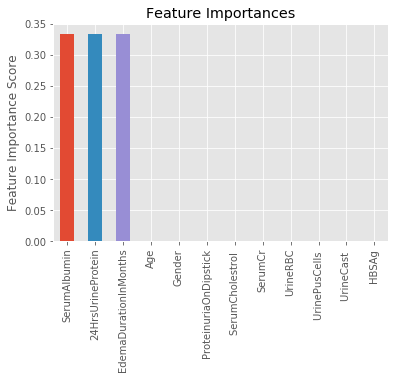

In [210]:
# #############################################################################
# Plot feature importance
feature_importance = pd.Series(dtree_model.feature_importances_,X.columns).nlargest(12)
feature_importance.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')